In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from strinng.gui.mpldraw import MplArtist

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [5]:
X, y = next(iter(train_dataloader))
X.shape

torch.Size([64, 1, 28, 28])

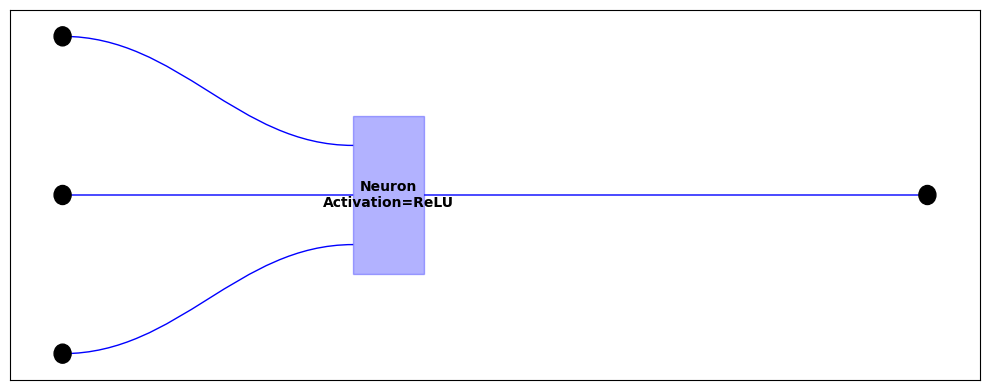

In [6]:
from strinng.generators import create_neuron

neuron = create_neuron(3, nn.ReLU)

MplArtist(neuron).draw(figsize=(10, 4))

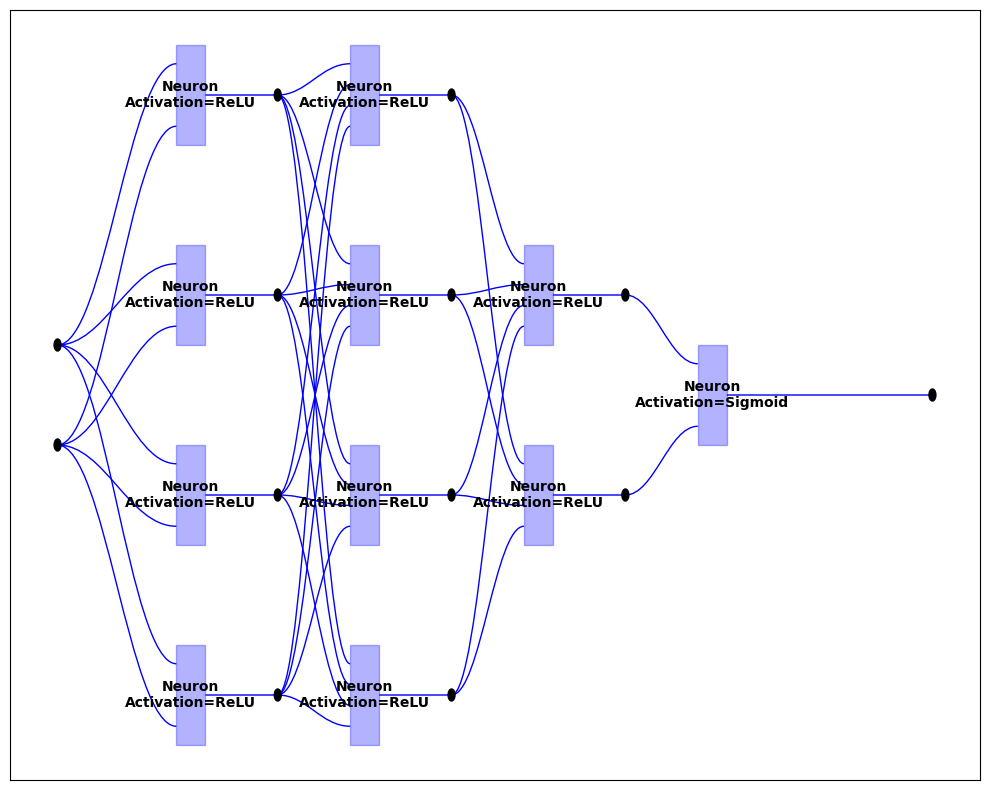

In [7]:
from strinng.generators import create_fully_connected

input_layer = create_fully_connected(2, 4, nn.ReLU)
hidden_1 = create_fully_connected(4, 4, nn.ReLU)
hidden_2 = create_fully_connected(4, 2, nn.ReLU)
output_layer = create_fully_connected(2, 1, nn.Sigmoid)
network = input_layer >> hidden_1 >> hidden_2 >> output_layer
MplArtist(network).draw()

In [66]:
from strinng.generators import create_fully_connected

input_layer = create_fully_connected(28 * 28, 64, nn.ReLU)
hidden_1 = create_fully_connected(64, 128, nn.ReLU)
hidden_2 = create_fully_connected(128, 64, nn.ReLU)
hidden_3 = create_fully_connected(64, 32, nn.ReLU)
output_layer = create_fully_connected(32, 10, nn.Sigmoid)
network = input_layer >> hidden_1 >> hidden_2 >> hidden_3 >> output_layer

In [71]:
import numpy as np
import pandas as pd

from strinng.generators import Neuron

def prune_connections(network):
    connections_added = 0
    connections_pruned = 0

    # Identify neurons in the hypergraph
    neurons = [e for e in network.edges.values()
            if isinstance(e.module, Neuron)]
    neuron_outputs = [network.vertices[neuron.targets[0]] for neuron in neurons]
    neuron_indices = [neuron.targets[0] for neuron in neurons]
    # Get activations of the neurons
    acts = torch.stack([v.cached_value for v in neuron_outputs], dim=1)
    acts_df = pd.DataFrame(acts.detach().numpy(),
                       columns=neuron_indices)
    # Get correlation between neuron activations
    acts_corr = acts_df.corr()
    # Find neuron pairs with low correlations
    uncorr = (-0.1 < acts_corr) * (acts_corr < 0.1)
    row_indices, col_indices = np.where(uncorr)
    pairs = []
    for row, col in zip(row_indices, col_indices):
        pairs.append((uncorr.index[row], uncorr.columns[col]))
    # 'Fire together, wire together'
    # Prune connections between neurons with uncorrelated activations
    for v1, v2 in pairs:
        targets = network.vertices[v1].targets
        remove = set()
        for target in targets:
            neuron = network.edges[target]
            if v2 == neuron.targets[0]:
                i = neuron.sources.index(v1)
                neuron.module.weights = nn.Parameter(
                    torch.cat((neuron.module.weights[:i],
                            neuron.module.weights[i+1:])
                ))
                neuron.sources = [v for v in neuron.sources if v != v1]
                remove.add(target)
                connections_pruned += 1
        network.vertices[v1].targets = targets - remove
    # Find neuron pairs with high correlations
    corr = (-0.1 > acts_corr) * (acts_corr > 0.1)
    row_indices, col_indices = np.where(corr)
    pairs = []
    for row, col in zip(row_indices, col_indices):
        pairs.append((corr.index[row], corr.columns[col]))
    # Add connections between neurons with correlated activations
    _, layers = network.frobenius_layer_decomp(in_place=True)
    vertex_layers = layers[::2]
    for v1, v2 in pairs:
        # If v2 occurs before v1, break to avoid creating cycles
        skip = False
        for layer in vertex_layers:
            if v1 in layer:
                break
            if v2 in layer:
                skip = True
                break
        if skip:
            continue
        # If already connected, no need to add a connection
        neuron_idx = network.vertices[v2].source[0]
        neuron = network.edges[neuron_idx]
        if v1 in neuron.sources:
            continue
        # Otherwise, connect the vertices
        network.vertices[v1].targets.add(neuron_idx)
        neuron.sources.append(v1)
        neuron.module.weights = nn.Parameter(
                    torch.cat((neuron.module.weights,
                            torch.randn(neuron.module.weights.shape[-1]))
        ))
        connections_added += 1
    return connections_added, connections_pruned



In [72]:
batch_size = 64

def train_loop(dataloader, model, optimizer, loss_fn):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X1 = X.flatten(2, -1).squeeze()
        X1 = [X1[:, i] for i in range(X1.shape[-1])]
        pred = model(*X1)
        pred = torch.stack(pred).T
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        if batch > 99 and batch % 100 == 0:
            a, p = prune_connections(network)
            print(f'Connections added: {a}\t Connections pruned: {p}')

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [73]:
learning_rate = 1e-3
epochs = 5

In [74]:
from torch.nn import CrossEntropyLoss

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_fn = CrossEntropyLoss()
train_loop(train_dataloader, network, optimizer, loss_fn)

loss: 1.747033  [   64/60000]
Connections added: 0	 Connections pruned: 476
loss: 1.660096  [ 6464/60000]
Connections added: 0	 Connections pruned: 410
loss: 1.618319  [12864/60000]
Connections added: 0	 Connections pruned: 286
loss: 1.680924  [19264/60000]


KeyboardInterrupt: 

In [ ]:
X, y = next(iter(train_dataloader))
X = X.flatten(2, -1).squeeze()
X = [X[:, i] for i in range(X.shape[-1])]

In [78]:
import matplotlib.pyplot as plt
import numpy as np

from strinng.generators import Neuron

network(*X)
neurons = [e for e in network.edges.values()
           if isinstance(e.module, Neuron)]
neuron_outputs = [network.vertices[neuron.targets[0]] for neuron in neurons]
neuron_indices = [neuron.targets[0] for neuron in neurons]
acts = torch.stack([v.cached_value for v in neuron_outputs], dim=1)

<Axes: >

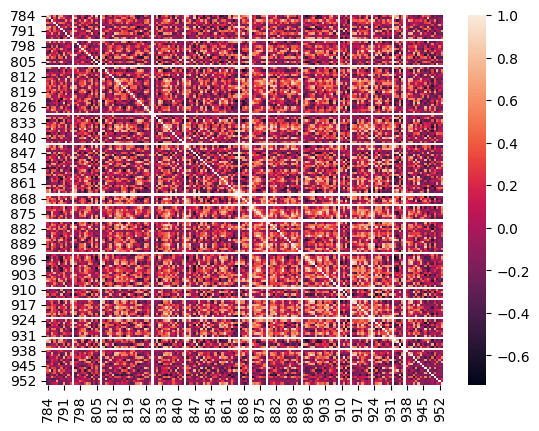

In [79]:



sns.heatmap(acts_df.corr())

In [62]:
acts_df = pd.DataFrame(acts.detach().numpy(),
                       columns=neuron_indices)
acts_corr = acts_df.corr()
uncorr = (-0.1 < acts_corr) * (acts_corr < 0.1)

row_indices, col_indices = np.where(uncorr)

pairs = []
for row, col in zip(row_indices, col_indices):
    pairs.append((uncorr.index[row], uncorr.columns[col]))
    for v1, v2 in pairs:
    targets = network.vertices[v1].targets
    remove = set()
    for target in targets:
        neuron = network.edges[target]
        if v2 == neuron.targets[0]:
            i = neuron.sources.index(v1)
            neuron.module.weights = nn.Parameter(
                torch.cat((neuron.module.weights[:i],
                           neuron.module.weights[i+1:])
            ))
            neuron.sources = [v for v in neuron.sources if v != v1]
            remove.add(target)
    network.vertices[v1].targets = targets - remove


ValueError: 784 is not in list